In [13]:
!pip install torch pillow jupyter torchvision numpy matplotlib

In [14]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import math
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets 
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import torch.nn.functional as F
import torch.optim as optim

In [15]:
# utilize gpu if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('You are using {device}'.format(device=device))

You are using cpu


In [16]:
# hyperparameters / specifics to tune our neural network
batch_size = 32 # number of inputs into neural network
learning_rate = 0.001      # lr: the speed at which your network "learns"

# the list of cifar10 classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [17]:
# downloading the dataset CIFAR10

# transforming the data to be interpretted by network easier
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# training data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
# test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
# two convolutional layers to customize
def three_channel_conv1(image): 
    if isinstance(image,(np.ndarray, np.generic)):
        image = torch.from_numpy(image)
    c = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=4, stride=1)
    d = nn.Dropout(.2)
    mp = nn.MaxPool2d(2)
    img = image
    out = c(img)
    out = d(out)
    out = mp(out)
    return out

def three_channel_conv2(image, dropout=.1, maxpool=2, kernelSize=4, kernelStride=1): 
    
    if isinstance(image, (np.ndarray, np.generic) ):
        image = torch.from_numpy(image)
    c = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=kernelSize, stride=kernelStride)
    d = nn.Dropout(dropout)
    mp = nn.MaxPool2d(maxpool)
    out = c(image)
    return out

# visualize convolutional layers output
def display_dataset(dataset, num_of_images=12, list_of_convs=[]):    
    cols = 4
    t = transforms.ToPILImage()
    rows = int(math.ceil((num_of_images/4)))
    fig_list = []
    image_grid_list = []
    for i in range(len(list_of_convs)+1):
        fig_list.append(plt.figure(figsize=(6.0, 6.0)))
        image_grid_list.append(ImageGrid(fig_list[i], 111, nrows_ncols=(rows, cols),
                     axes_pad=0.1))
    
    for j in range(num_of_images):
        reg_img = dataset[j][0]
        image_grid_list[0][j].imshow(t(reg_img))
        
    for i in range(len(list_of_convs)):
        for j in range(num_of_images):
            img = dataset[j][0]
            img = list_of_convs[i](img)
            image_grid_list[i+1][j].imshow(t(img))
    plt.show()

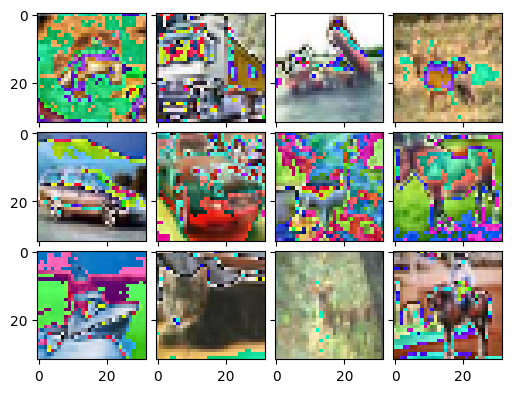

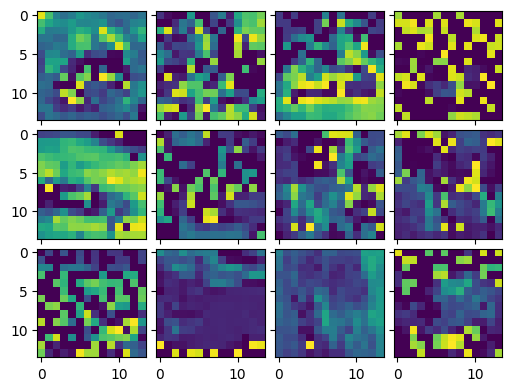

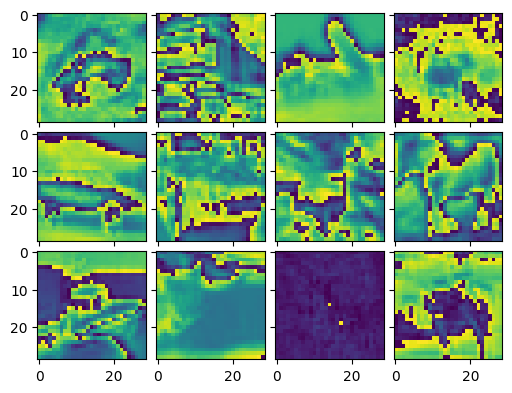

In [19]:
# print dataset
display_dataset(trainset, list_of_convs=[three_channel_conv1, three_channel_conv2])

In [20]:
# network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

# uses GPU if available
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [21]:
# formula for calculating how correct the network is
criterion = nn.CrossEntropyLoss()

# how we decide to improve the network
# adam is the current state of the art optimizer
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# load dataset if you want to, comment out if you don't want to
net.load_state_dict(torch.load('./nets/cifar10-best'))

<All keys matched successfully>

In [22]:
best_loss = 0.2
for epoch in range(2):  # loop over the dataset multiple times

    curr_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        curr_loss += loss.item()
        if i % 500 == 0:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {curr_loss / 2000:.3f}')
            curr_loss = 0.0
        
            if curr_loss < best_loss and i != 0:
                best_loss = curr_loss
                # torch.save(net.state_dict(), './nets/cifar10-{loss}'.format(loss=curr_loss))
                
                # make sure you load dataset if you want to run this as it will overwrite the previous weights
                torch.save(net.state_dict(), './nets/cifar10-best'.format(loss=curr_loss))
                print('saving best model')
                
print('Finished Training')

[1,     1] loss: 0.000
[1,   501] loss: 0.157
saving best model
[1,  1001] loss: 0.161
[1,  1501] loss: 0.168
[2,     1] loss: 0.000
[2,   501] loss: 0.150
[2,  1001] loss: 0.159
[2,  1501] loss: 0.163
Finished Training


In [23]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 63 %


In [24]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 68.6 %
Accuracy for class: car   is 75.9 %
Accuracy for class: bird  is 59.0 %
Accuracy for class: cat   is 41.3 %
Accuracy for class: deer  is 60.0 %
Accuracy for class: dog   is 47.6 %
Accuracy for class: frog  is 72.6 %
Accuracy for class: horse is 57.7 %
Accuracy for class: ship  is 77.6 %
Accuracy for class: truck is 70.0 %
